# ITI5212 - 2024
# Assessment 1
    
#### Eddy_33495068


Date: 19/08/2024

All code is run in Python 3 provided by Google Colab

## **Part 1: Text Classification**



Mount Google Drive if needed


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the library needed to run the code and setting the random seed

In [62]:
%matplotlib inline
#Importing the library
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
import string
import re
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext import data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Setting the random seed
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the dataset from drive, then print the specification of the dataset and checking proportion of the label for computational linguistic

In [63]:
# Load the dataset into a pandas dataframe.
#If using google drive
#df_train = pd.read_csv("/content/drive/MyDrive/NLP/train_set.csv")
#df_dev = pd.read_csv("/content/drive/MyDrive/NLP/dev_set.csv")
#df_test = pd.read_csv("/content/drive/MyDrive/NLP/test_set.csv")

#From local folder
df_train = pd.read_csv("./train_set.csv")
df_dev = pd.read_csv("./dev_set.csv")
df_test = pd.read_csv("./test_set.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of dev sentences: {:,}\n'.format(df_dev.shape[0]))
print('Number of testing sentences: {:,}\n'.format(df_test.shape[0]))

# Report proportions
print('Proportion of 0 class in training sentences: {:.4f}\n'.format(df_train.loc[df_train.ComputationalLinguistics == 0].shape[0] / df_train.shape[0]))  # label 0 --> there are grammatically mistakes
print('Proportion of 1 class in training sentences: {:.4f}\n'.format(df_train.loc[df_train.ComputationalLinguistics == 1].shape[0] / df_train.shape[0]))  # label 1 --> no grammatically mistakes

Number of training sentences: 152,586

Number of dev sentences: 19,073

Number of testing sentences: 19,074

Proportion of 0 class in training sentences: 0.7299

Proportion of 1 class in training sentences: 0.2701



Display 10 sample of the dataset

In [64]:
# Display 10 random rows from the data.
df_train.sample(10)

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
51957,Rudin-Shapiro-Like Sequences with Maximum Asym...,Borwein and Mossinghoff investigated the Rud...,1,0,0
108290,Scaling Up Your Kernels to 31x31: Revisiting L...,We revisit large kernel design in modern con...,0,0,1
49906,"Personal Entity, Concept, and Named Entity Lin...",Building conversational agents that can have...,0,1,0
56901,Deep Learning-Based Pilotless Spatial Multiple...,This paper investigates the feasibility of m...,1,0,0
19664,Enhancing Computation Efficiency in Large Lang...,Large Language Models (LLMs) are proficient ...,0,1,0
52228,Mitigating Object Hallucinations in Large Visi...,Large Vision-Language Models (LVLMs) have ad...,0,0,1
7381,Effective Sequential Classifier Training for S...,The explosive availability of remote sensing...,0,0,1
66718,Skeleton-based Human Action Recognition via Co...,"Recently, there has been a remarkable increa...",0,0,1
108760,Let's Talk! Striking Up Conversations via Conv...,An engaging and provocative question can ope...,0,0,1
37688,"Closed-form, robust and accurate multi-frequen...","A closed-form algorithm, named ""concerto"", i...",1,0,0


Display some data that belongs to class 0 of computational linguistics

In [65]:
# some data samples belong to class 0
df_train.loc[df_train.ComputationalLinguistics == 0].sample(5)[['title', 'abstract', 'ComputationalLinguistics']]

,title,abstract,ComputationalLinguistics
43658,DifAttack: Query-Efficient Black-Box Attack vi...,This work investigates efficient score-based...,0
44369,On the Effectiveness of Image Rotation for Ope...,Open Set Domain Adaptation (OSDA) bridges th...,0
34996,Temporal Adaptive RGBT Tracking with Modality ...,RGBT tracking has been widely used in variou...,0
127236,Self-Attention Capsule Networks for Object Cla...,We propose a novel architecture for object c...,0
31967,Towards cumulative race time regression in spo...,Predicting an athlete's performance based on...,0


Preparing the abstract train dataset for model training.

In [66]:
#Preparing the train dataset in a list form

'''
Combining only the abstract and computational linguistic column and converting
them to list form
'''
abs_train_combined = list(zip(df_train.abstract.tolist(),
                            df_train.ComputationalLinguistics.tolist()))
svm_abs_a1, svm_abs_a2 = zip(*abs_train_combined) #Splitting to trainDocs, trainLabel

#Subsetting only the first 1000 datas from the list
svm_abs_a1sub = svm_abs_a1[:1000] #trainDocs_subset
svm_abs_a2sub = svm_abs_a2[:1000] #trainLabel_subset

Preparing the abstract test dataset for testing the model.

In [67]:
#Preparing the test dataset converting it to list form
#Combining both dataset into one list
abs_test_combined = list(zip(df_test.abstract.tolist(),
                             df_test.ComputationalLinguistics.tolist()))
#Splitting into train and label test list
svm_abs_b1, svm_abs_b2 = zip(*abs_test_combined) #testDocs, testLabel

In [68]:
#Checking the subsetted result
print(len(svm_abs_a1sub))


1000


Before building the model we first need to define the tokenizer to tokenize the documents. This tokenizer aim to keep the ! and ? symbols while deleting the other symbols

In [69]:
class LemmaTokenizer(object):
    def __init__(self):
        # Initialize a WordNet lemmatize to reduce a word to its root form
        self.wnl = WordNetLemmatizer()
        # Create a set of English stopwords to filter out typical words
        self.stop_words = set(stopwords.words('english'))
        # Removing symbols except ! and ?
        self.punctuation = set(string.punctuation) - {'!', '?'}

    def __call__(self, doc):
        # Tokenize the input document into words and punctuation
        tokens = wordpunct_tokenize(doc)
        # Lemmatizing each token returning only the words that are not in stop_words and self.punctuation
        return [self.wnl.lemmatize(t.lower()) for t in tokens if t.lower() not in self.stop_words and t not in self.punctuation]


After building the LemmaTokenizer we next build the vectorizer. This vectorizer uses the TF-IDF and convert the raw documents into matrix

In [70]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
#Setting the extraction features based on individual words and the input will be the raw conent
abs_vectorizer = TfidfVectorizer(analyzer='word',input='content',
                           #Setting the minimum document frequency
                           min_df=3,
                           #Setting the gram range to be uni and bgram
                           ngram_range=(1,2),
                           #Setting the tokenizer to be LemmaTokenizer
                           tokenizer=LemmaTokenizer())

Using the vectorizer on the train subsetted abstract data and converting the target label as array

In [71]:
abs_x_train_subs =abs_vectorizer.fit_transform(svm_abs_a1sub)  # input features of a collection of the subsetted training data
abs_y_train_subs =np.asarray(svm_abs_a2sub)  #subsetted training labels

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Using the SVM linear model for training the model. We first use the subsetted list

In [72]:
# Use the same subsetted vectorizer to transform the subsetted test set
abs_x_test_subset=abs_vectorizer.transform(svm_abs_b1)
abs_y_test_subset=np.asarray(svm_abs_b2)

In [73]:
#Using the SVM linear model for training the subsetted data
model_abs_subset = LinearSVC()

# Train the model on the subsetted training data
model_abs_subset.fit(abs_x_train_subs, abs_y_train_subs)



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

Use the trained model on the test data then evaluate the model by using

*   Confusion Matrix
*   F1 score
* Precision
* Recall
* Accuracy
* MCC



In [74]:
# Do the prediction on the subsetted data using weighted method

abs_y_predict_subset = model_abs_subset.predict(abs_x_test_subset) # prediction
print(confusion_matrix(abs_y_test_subset,abs_y_predict_subset)) #Printing the Confusion Matrix
abs_recall_subset=recall_score(abs_y_test_subset,abs_y_predict_subset,average='weighted') #Calculating the recall score
abs_precision_subset=precision_score(abs_y_test_subset,abs_y_predict_subset,average='weighted') #Calculating the precision score
abs_f1score_subset=f1_score(abs_y_test_subset,abs_y_predict_subset,average='weighted') #Calculating the f1score
abs_accuracy_subset=accuracy_score(abs_y_test_subset,abs_y_predict_subset) #Calculating the accuracy
#Calculating the Matthews Correlation Coefficient to evaluate the model
abs_matthews_subset = matthews_corrcoef(abs_y_test_subset,abs_y_predict_subset)

#printing the result
print('Accuracy: '+ str(abs_accuracy_subset))
print('Macro Precision: '+ str(abs_precision_subset))
print('Macro Recall: '+ str(abs_recall_subset))
print('Macro F1 score:'+ str(abs_f1score_subset))
print('MCC:'+ str(abs_matthews_subset))

[[13823   245]
 [  863  4143]]
Accuracy: 0.9419104540211807
Macro Precision: 0.942005365498284
Macro Recall: 0.9419104540211807
Macro F1 score:0.9406239445427674
MCC:0.8469625207782246


In [75]:
# Do the prediction on the subsetted data using binary method

abs_y_predict_subset = model_abs_subset.predict(abs_x_test_subset) # prediction
print(confusion_matrix(abs_y_test_subset,abs_y_predict_subset)) #Printing the Confusion Matrix
abs_recall_subset_b=recall_score(abs_y_test_subset,abs_y_predict_subset,average='binary') #Calculating the recall score
abs_precision_subset_b=precision_score(abs_y_test_subset,abs_y_predict_subset,average='binary') #Calculating the precision score
abs_f1score_subset_b=f1_score(abs_y_test_subset,abs_y_predict_subset,average='binary') #Calculating the f1score
abs_accuracy_subset_b=accuracy_score(abs_y_test_subset,abs_y_predict_subset) #Calculating the accuracy
#Calculating the Matthews Correlation Coefficient to evaluate the model
abs_matthews_subset = matthews_corrcoef(abs_y_test_subset,abs_y_predict_subset)

#printing the result
print('Accuracy: '+ str(abs_accuracy_subset_b))
print('Macro Precision: '+ str(abs_precision_subset_b))
print('Macro Recall: '+ str(abs_recall_subset_b))
print('Macro F1 score:'+ str(abs_f1score_subset_b))
print('MCC:'+ str(abs_matthews_subset))

[[13823   245]
 [  863  4143]]
Accuracy: 0.9419104540211807
Macro Precision: 0.9441659070191432
Macro Recall: 0.8276068717538954
Macro F1 score:0.8820523738556526
MCC:0.8469625207782246


Plotting the precision recall curve to evaluate the model further

Text(0.5, 1.0, 'Subsetted Abstract Statistical Precision-Recall curve')

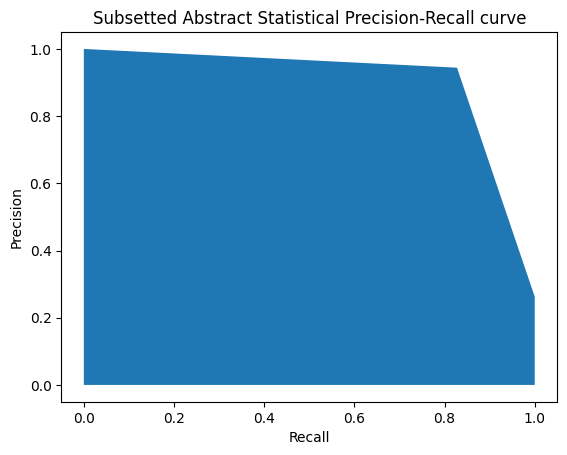

In [76]:
#Using precision recall curve to make the necessary variable to make the curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(abs_y_test_subset, abs_y_predict_subset)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Subsetted Abstract Statistical Precision-Recall curve")

Using the vectorizer on the train abstract data and converting the target label as array

In [77]:
abs_x_train =abs_vectorizer.fit_transform(svm_abs_a1)  # input features of a collection of training data
abs_y_train =np.asarray(svm_abs_a2)  # training labels

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [78]:
# Use the same vectorizer to transform the test set
abs_x_test=abs_vectorizer.transform(svm_abs_b1)
abs_y_test=np.asarray(svm_abs_b2)

Using the SVM linear model for training the model. We first use the subsetted list

In [79]:
# Do the prediction on the whole data

model_abs = LinearSVC()

# Train the model on the training data
model_abs.fit(abs_x_train, abs_y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

Use the trained model on the test data then evaluate the model by using

*   Confusion Matrix
*   F1 score
* Precision
* Recall
* Accuracy
* MCC



In [80]:
# Do the prediction on all the abstract data using weighted method

abs_y_predict = model_abs.predict(abs_x_test) # prediction
print(confusion_matrix(abs_y_test,abs_y_predict)) #Printing the Confusion Matrix
abs_recall=recall_score(abs_y_test,abs_y_predict,average='weighted') #Calculating the recall score
abs_precision=precision_score(abs_y_test,abs_y_predict,average='weighted') #Calculating the precision score
abs_f1score=f1_score(abs_y_test,abs_y_predict,average='weighted') #Calculating the f1score
abs_accuracy=accuracy_score(abs_y_test,abs_y_predict) #Calculating the accuracy
#Calculating the Matthews Correlation Coefficient to evaluate the model
abs_matthews = matthews_corrcoef(abs_y_test,abs_y_predict)

#printing the result
print('Accuracy: '+ str(abs_accuracy))
print('Macro Precision: '+ str(abs_precision))
print('Macro Recall: '+ str(abs_recall))
print('Macro F1 score:'+ str(abs_f1score))
print('MCC:'+ str(abs_matthews))

[[13894   174]
 [  223  4783]]
Accuracy: 0.979186326937192
Macro Precision: 0.9791367326926268
Macro Recall: 0.979186326937192
Macro F1 score:0.9791532364862436
MCC:0.9460884804696379


In [81]:
# Do the prediction on all the abstract data using binary method

abs_y_predict = model_abs.predict(abs_x_test) # prediction
print(confusion_matrix(abs_y_test,abs_y_predict)) #Printing the Confusion Matrix
abs_recall_b=recall_score(abs_y_test,abs_y_predict,average='binary') #Calculating the recall score
abs_precision_b=precision_score(abs_y_test,abs_y_predict,average='binary') #Calculating the precision score
abs_f1score_b=f1_score(abs_y_test,abs_y_predict,average='binary') #Calculating the f1score
abs_accuracy_b=accuracy_score(abs_y_test,abs_y_predict) #Calculating the accuracy
#Calculating the Matthews Correlation Coefficient to evaluate the model
abs_matthews = matthews_corrcoef(abs_y_test,abs_y_predict)

#printing the result
print('Accuracy: '+ str(abs_accuracy_b))
print('Macro Precision: '+ str(abs_precision_b))
print('Macro Recall: '+ str(abs_recall_b))
print('Macro F1 score:'+ str(abs_f1score_b))
print('MCC:'+ str(abs_matthews))

[[13894   174]
 [  223  4783]]
Accuracy: 0.979186326937192
Macro Precision: 0.9648981238652411
Macro Recall: 0.9554534558529765
Macro F1 score:0.960152564488608
MCC:0.9460884804696379


Plotting the precision recall curve to evaluate the model further

Text(0.5, 1.0, 'Full Abstract Statitistical Precision-Recall curve')

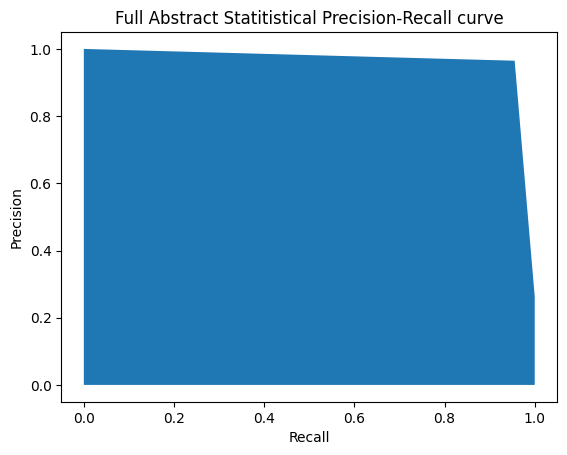

In [82]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(abs_y_test, abs_y_predict)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Full Abstract Statitistical Precision-Recall curve")

We collect the evaluation for both subsetted abstract and full abstract data then display the evaluation for both weighted and binary style calculation

In [83]:

# Create a dictionary to hold the subsetted and full abstract evaluation
abs_data_w = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'AbsFull_W': [abs_accuracy, abs_precision, abs_recall, abs_f1score],
    'AbsSubset_W': [abs_accuracy_subset, abs_precision_subset, abs_recall_subset, abs_f1score_subset]
}

# Create a pandas DataFrame from the dictionary
abs_df_w = pd.DataFrame(abs_data_w)

# Display the dictionary for the evaluation of the model
print('Weighted Evaluation for Abstract')
print(abs_df_w)


Weighted Evaluation for Abstract
      Metric  AbsFull_W  AbsSubset_W
0   Accuracy   0.979186     0.941910
1  Precision   0.979137     0.942005
2     Recall   0.979186     0.941910
3   F1-score   0.979153     0.940624


In [84]:
# Create a dictionary to hold the subsetted and full abstract evaluation
abs_data_b = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'AbsFull_B': [abs_accuracy_b, abs_precision_b, abs_recall_b, abs_f1score_b],
    'AbsSubset_B': [abs_accuracy_subset_b, abs_precision_subset_b, abs_recall_subset_b, abs_f1score_subset_b]
}

# Create a pandas DataFrame from the dictionary
abs_df_b = pd.DataFrame(abs_data_b)

# Display the dictionary for the evaluation of the model
print('Binary Evaluation for Abstract')
print(abs_df_b)

Binary Evaluation for Abstract
      Metric  AbsFull_B  AbsSubset_B
0   Accuracy   0.979186     0.941910
1  Precision   0.964898     0.944166
2     Recall   0.955453     0.827607
3   F1-score   0.960153     0.882052


Now for the classification with title

In [85]:
#Preparing the title train dataset in a list form

'''
Combining only the title and computational linguistic column and converting
them to list form
'''
title_train_combined = list(zip(df_train.title.tolist(),
                              df_train.ComputationalLinguistics.tolist()))
title_train_combined = [(title.lower(), label) for title, label in title_train_combined]
svm_title_a1, svm_title_a2 = zip(*title_train_combined) #Splitting to trainDocs, trainLabel

# Subsetting only the first 1000 datas from the list
svm_title_a1sub = svm_title_a1[:1000] #trainDocs_subset
svm_title_a2sub = svm_title_a2[:1000] #trainLabel_subset

Preparing the Title test dataset for testing the model.

In [86]:
#Preparing the title test dataset converting it to list form
title_test_combined = list(zip(df_train.title.tolist(),
                             df_test.ComputationalLinguistics.tolist()))
title_test_combined = [(title.lower(), label) for title, label in title_test_combined]
svm_title_b1, svm_title_b2 = zip(*title_test_combined) #testDocs, testLabel

Build the same vectorizer for the title document to not overlap with the abstract

In [87]:
#Vectorizer a collection of raw documents into matrix of TF-IDF features
title_vectorizer = TfidfVectorizer(analyzer='word',input='content',
                           min_df=3,
                           ngram_range=(1,2),
                           tokenizer=LemmaTokenizer())

Apply the vectorizer for the title train subsetted dataset and convert the titlelabel subsetted dataset to arrayform

In [88]:
title_x_train_subs =title_vectorizer.fit_transform(svm_title_a1sub)  # input features of a collection of the subsetted training data
title_y_train_subs =np.asarray(svm_title_a2sub)  #subsetted training labels

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Apply the vectorizer for the title test subsetted dataset and convert the title teest label subsetted dataset to arrayform

In [89]:
# Use the same subsetted vectorizer to transform the subsetted test set
title_x_test_subset=title_vectorizer.transform(svm_title_b1)
title_y_test_subset=np.asarray(svm_title_b2)

Applying the SVM linear model for the subsetted title data

In [90]:
#Using the SVM linear model for training the subsetted data
model_title_subset = LinearSVC()

# Train the model on the subsetted training data
model_title_subset.fit(title_x_train_subs, title_y_train_subs)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

Use the trained model on the test data then evaluate the model by using

*   Confusion Matrix
*   F1 score
* Precision
* Recall
* Accuracy
* MCC



In [91]:
# Do the prediction on the subsetted title data using weighted style

title_y_predict_subset = model_title_subset.predict(title_x_test_subset) # prediction

print(confusion_matrix(title_y_test_subset,title_y_predict_subset)) #Printing the Confusion Matrix

title_recall_subset=recall_score(title_y_test_subset,title_y_predict_subset,average='weighted') #Calculating the recall score

title_precision_subset=precision_score(title_y_test_subset,title_y_predict_subset,average='weighted') #Calculating the precision score

title_f1score_subset=f1_score(title_y_test_subset,title_y_predict_subset,average='weighted') #Calculating the f1score

title_accuracy_subset=accuracy_score(title_y_test_subset,title_y_predict_subset) #Calculating the accuracy

#Calculating the matthews correlation coefficient to evaluate the model
title_matthews_subset = matthews_corrcoef(title_y_test_subset,title_y_predict_subset)

#printing the result
print('Accuracy: '+ str(title_accuracy_subset))
print('Macro Precision: '+ str(title_precision_subset))
print('Macro Recall: '+ str(title_recall_subset))
print('Macro F1 score:'+ str(title_f1score_subset))
print('MCC:'+ str(title_matthews_subset))

[[10950  3118]
 [ 3949  1057]]
Accuracy: 0.6294956485267904
Macro Precision: 0.6085060801976045
Macro Recall: 0.6294956485267904
Macro F1 score:0.6180423959263204
MCC:-0.011162906695248569


In [92]:
# Do the prediction on the subsetted title data using binary style

title_y_predict_subset = model_title_subset.predict(title_x_test_subset) # prediction

print(confusion_matrix(title_y_test_subset,title_y_predict_subset)) #Printing the Confusion Matrix

title_recall_subset_b=recall_score(title_y_test_subset,title_y_predict_subset,average='binary') #Calculating the recall score

title_precision_subset_b=precision_score(title_y_test_subset,title_y_predict_subset,average='binary') #Calculating the precision score

title_f1score_subset_b=f1_score(title_y_test_subset,title_y_predict_subset,average='binary') #Calculating the f1score

title_accuracy_subset_b=accuracy_score(title_y_test_subset,title_y_predict_subset) #Calculating the accuracy

#Calculating the matthews correlation coefficient to evaluate the model
title_matthews_subset = matthews_corrcoef(title_y_test_subset,title_y_predict_subset)

#printing the result
print('Accuracy: '+ str(title_accuracy_subset_b))
print('Macro Precision: '+ str(title_precision_subset_b))
print('Macro Recall: '+ str(title_recall_subset_b))
print('Macro F1 score:'+ str(title_f1score_subset_b))
print('MCC:'+ str(title_matthews_subset))

[[10950  3118]
 [ 3949  1057]]
Accuracy: 0.6294956485267904
Macro Precision: 0.2531736526946108
Macro Recall: 0.21114662405113863
Macro F1 score:0.23025814181461718
MCC:-0.011162906695248569


Plotting the precision recall curve to evaluate the model further

Text(0.5, 1.0, 'Subsetted Title Dataset Statistical Precision-Recall curve')

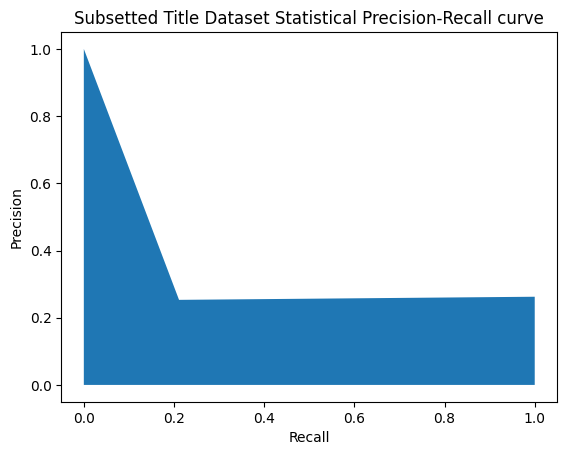

In [93]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(title_y_test_subset, title_y_predict_subset)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Subsetted Title Dataset Statistical Precision-Recall curve")

Next we're going to do the same thing on all test dataset. First we vectorize all the title train dataset and convert the label for it to array

In [94]:
#Use the vectorizer to train on all test dataset
title_x_train =title_vectorizer.fit_transform(svm_title_a1)  # input features of a collection of training data
title_y_train =np.asarray(svm_title_a2)  # training labels

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Then use the same method but for the title test set

In [95]:
# Use the same vectorizer to transform the test set
title_x_test=title_vectorizer.transform(svm_title_b1)
title_y_test=np.asarray(svm_title_b2)

Next we build apply the SVM linear model and apply it to the title dataset

In [96]:
#Using the SVM linear model for training the subsetted data
model_title = LinearSVC()

# Train the model on the subsetted training data
model_title.fit(title_x_train, title_y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

Use the trained model on the test data then evaluate the model by using

*   Confusion Matrix
*   F1 score
* Precision
* Recall
* Accuracy
* MCC



In [97]:
# Do the prediction on all the data using weighted style evaluation

title_y_predict = model_title.predict(title_x_test) # prediction
print(confusion_matrix(title_y_test,title_y_predict))
title_recall=recall_score(title_y_test,title_y_predict,average='weighted')
title_precision=precision_score(title_y_test,title_y_predict,average='weighted')
title_f1score=f1_score(title_y_test,title_y_predict,average='weighted')
title_accuracy=accuracy_score(title_y_test,title_y_predict)
# The higher the better: The MCC is in essence a correlation coefficient value between -1 and +1.
# A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
title_matthews = matthews_corrcoef(title_y_test,title_y_predict)
print('Accuracy: '+ str(title_accuracy))
print('Macro Precision: '+ str(title_precision))
print('Macro Recall: '+ str(title_recall))
print('Macro F1 score:'+ str(title_f1score))
print('MCC:'+ str(title_matthews))

[[10163  3905]
 [ 3681  1325]]
Accuracy: 0.6022858341197441
Macro Precision: 0.6079317821733627
Macro Recall: 0.6022858341197441
Macro F1 score:0.6050416604292551
MCC:-0.012720389683806623


In [98]:
# Do the prediction on all the data using binary style evaluation

title_y_predict = model_title.predict(title_x_test) # prediction
print(confusion_matrix(title_y_test,title_y_predict))
title_recall_b=recall_score(title_y_test,title_y_predict,average='binary')
title_precision_b=precision_score(title_y_test,title_y_predict,average='binary')
title_f1score_b=f1_score(title_y_test,title_y_predict,average='binary')
title_accuracy_b=accuracy_score(title_y_test,title_y_predict)
# The higher the better: The MCC is in essence a correlation coefficient value between -1 and +1.
# A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
title_matthews = matthews_corrcoef(title_y_test,title_y_predict)
print('Accuracy: '+ str(title_accuracy_b))
print('Macro Precision: '+ str(title_precision_b))
print('Macro Recall: '+ str(title_recall_b))
print('Macro F1 score:'+ str(title_f1score_b))
print('MCC:'+ str(title_matthews))

[[10163  3905]
 [ 3681  1325]]
Accuracy: 0.6022858341197441
Macro Precision: 0.25334608030592737
Macro Recall: 0.2646823811426288
Macro F1 score:0.25889019148104725
MCC:-0.012720389683806623


Plotting the precision recall curve to evaluate the model further

Text(0.5, 1.0, 'All Title Dataset Statistical Precision-Recall curve')

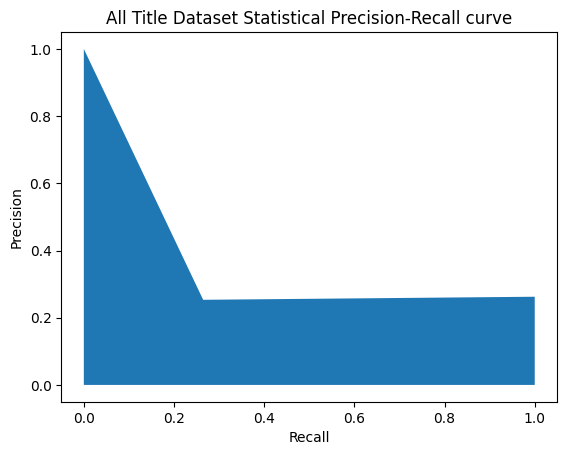

In [99]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(title_y_test, title_y_predict)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("All Title Dataset Statistical Precision-Recall curve")

We collect the evaluation for both subsetted title and full titledata then display the evaluation metric for both model

In [100]:
# Create a dictionary to hold the evaluation metric
title_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'TitleFull_B': [title_accuracy, title_precision, title_recall, title_f1score],
    'TitleSubset_B': [title_accuracy_subset, title_precision_subset, title_recall_subset, title_f1score_subset]
}

# Create a dataframe to hold the evaluation data
title_df = pd.DataFrame(title_data)

# Display the evaluation for all title and subsetted title evaluation metric
print('Title Weighted Evaluation')
print(title_df)

Title Weighted Evaluation
      Metric  TitleFull_B  TitleSubset_B
0   Accuracy     0.602286       0.629496
1  Precision     0.607932       0.608506
2     Recall     0.602286       0.629496
3   F1-score     0.605042       0.618042


In [101]:
# Create a dictionary to hold the evaluation metric
title_data_b = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'TitleFull_B': [title_accuracy_b, title_precision_b, title_recall_b, title_f1score_b],
    'TitleSubset_B': [title_accuracy_subset_b, title_precision_subset_b, title_recall_subset_b, title_f1score_subset_b]
}

# Create a dataframe to hold the evaluation data
title_df_b = pd.DataFrame(title_data_b)

# Display the evaluation for all title and subsetted title evaluation metric
print('Title Binary Evaluation')
print(title_df_b)

Title Binary Evaluation
      Metric  TitleFull_B  TitleSubset_B
0   Accuracy     0.602286       0.629496
1  Precision     0.253346       0.253174
2     Recall     0.264682       0.211147
3   F1-score     0.258890       0.230258


Combining the evaluation metrics that is calculated using weighted for both title and abstract then show them together

In [102]:
#Combine the evaluation metric for title and abstract
merge_df_w = pd.merge(abs_df_w, title_df, on='Metric')
#Show the dataframe
print('Evaluation metric using Weighted')
merge_df_w

Evaluation metric using Weighted


,Metric,AbsFull_W,AbsSubset_W,TitleFull_B,TitleSubset_B
0,Accuracy,0.979186,0.941910,0.602286,0.629496
1,Precision,0.979137,0.942005,0.607932,0.608506
2,Recall,0.979186,0.941910,0.602286,0.629496
3,F1-score,0.979153,0.940624,0.605042,0.618042


Plotting the dodged barchart for weighted evaluation metric for both Abstract and Title

Combining the evaluation metrics that is calculated using weighted for both title and abstract then show them together

In [103]:
#Combine the evaluation metric for title and abstract
merge_df_b = pd.merge(abs_df_b, title_df_b, on='Metric')
#Show the dataframe
print('Evaluation metric using Binary')
merge_df_b

Evaluation metric using Binary


,Metric,AbsFull_B,AbsSubset_B,TitleFull_B,TitleSubset_B
0,Accuracy,0.979186,0.941910,0.602286,0.629496
1,Precision,0.964898,0.944166,0.253346,0.253174
2,Recall,0.955453,0.827607,0.264682,0.211147
3,F1-score,0.960153,0.882052,0.258890,0.230258


Next up we're going to use RNN to classify the abstract and title dataset first we make the tokenizer

In [104]:
#Tokenizer
tokenizer = get_tokenizer('basic_english')

In [105]:
#Yield Tokens
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Loading the dataset
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        next(f)  # Skip the first line
        for line in f:
            label, text = [line.split('\t')[1], line.split('\t')[3]]
            data.append((int(label), text.strip()))
    return data

Now we need to build the vocabulary for the Abstract dataset first

In [106]:
# Select the 'ComputationalLinguistics' and 'abstract' columns from the df_train DataFrame
# and assign them to the variable rnn_vocab
rnn_vocab_abs = df_train[['ComputationalLinguistics', 'abstract']]

# Convert the selected columns to a list of lists (where each inner list contains the values from both columns for a single row)
rnn_vocab_abs = rnn_vocab_abs.values.tolist()

In [107]:
# Build vocabulary
vocab_abs = build_vocab_from_iterator(yield_tokens(rnn_vocab_abs), specials=["<unk>"])
vocab_abs.set_default_index(vocab_abs["<unk>"])

# Data processing
def text_pipeline(x):
    return vocab_abs(tokenizer(x))

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=vocab_abs["<unk>"])

In [108]:
# Print the first 10 words in the vocabulary
print("Vocabulary Sample:", list(vocab_abs.get_itos())[:10])

# Extract unique labels from the training data
unique_labels = set(label for label, _ in rnn_vocab_abs)
print("Unique Labels:", unique_labels)

vocab_abs_size = len(list(vocab_abs.get_itos()))
print(f"Unique tokens in TEXT vocabulary: {vocab_abs_size}")
print(f"Unique tokens in LABEL vocabulary: {len(unique_labels)}")

Vocabulary Sample: ['<unk>', 'the', '.', ',', 'of', 'and', 'to', 'a', 'in', 'we']
Unique Labels: {0, 1}
Unique tokens in TEXT vocabulary: 305129
Unique tokens in LABEL vocabulary: 2


In [109]:
from torch.utils.data import Dataset  # Import the Dataset class from PyTorch

class TextDataset(Dataset):  # Define a custom dataset class named TextDataset that inherits from PyTorch's Dataset class.
    def __init__(self, data):
        self.data = data  #

    def __len__(self):
        return len(self.data)  # Return the total number of samples in the dataset

    def __getitem__(self, idx):
        return self.data[idx]  # Retrieve and return a single sample from the dataset based on the index 'idx'


Next we'll prepare the dataset for both abstract and title for the train and test dataset

In [110]:
#Preparing the train dataset
rnn_abs_train = TextDataset(df_train[['ComputationalLinguistics','abstract']].values.tolist())
#Preparing the test dataset
rnn_abs_test = TextDataset(df_test[['ComputationalLinguistics','abstract']].values.tolist())


In [111]:
#Preparing the train dataset
rnn_title_train = TextDataset(df_train[['ComputationalLinguistics','abstract']].values.tolist())
#Preparing the test dataset
rnn_title_test = TextDataset(df_test[['ComputationalLinguistics','abstract']].values.tolist())


Next we'll need to prepared subsetted dataset for title and test then use dataloader to load the dataset so that it can be used for RNN

In [112]:
from torch.utils.data import Subset

# Create subsets of the first 1000 samples for the abstract dataset
subset_indices = list(range(1000))
rnn_abs_train_subset = Subset(rnn_abs_train, subset_indices)
rnn_abs_test_subset = Subset(rnn_abs_test, subset_indices)

# Create DataLoaders for the subsets for the abstract dataset
rnn_abs_train_loader_subset = DataLoader(rnn_abs_train_subset, batch_size=32, shuffle=True, collate_fn=collate_batch)


Dataloader for abstract

In [113]:
# Create DataLoaders for the abstract dataset
rnn_abs_train_loader = DataLoader(rnn_abs_train, batch_size=32, shuffle=True, collate_fn=collate_batch)
rnn_abs_test_loader = DataLoader(rnn_abs_test, batch_size=32, shuffle=False, collate_fn=collate_batch)


Subsetting title and dataloading the subsetted dataset

In [114]:
# Create subsets of the first 1000 samples for the title dataset
rnn_title_train_subset = Subset(rnn_title_train, subset_indices)
rnn_title_test_subset = Subset(rnn_title_test, subset_indices)

# Create DataLoaders for the subsets for the title dataset
rnn_title_train_loader_subset = DataLoader(rnn_title_train_subset, batch_size=32, shuffle=True, collate_fn=collate_batch)


Dataloading the entire title dataset

In [115]:
# Create DataLoaders for the title dataset
rnn_title_train_loader = DataLoader(rnn_title_train, batch_size=32, shuffle=True, collate_fn=collate_batch)
rnn_title_test_loader = DataLoader(rnn_title_test, batch_size=32, shuffle=False, collate_fn=collate_batch)


Next we'll definte the RNN that we'll use for this section from pytorch

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
import torch.nn as nn # Import the neural network module from PyTorch

# Define an RNN class that inherits from nn.Module
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):

        super().__init__() # Call the constructor of the parent class (nn.Module)

        # Define an embedding layer that converts input indices into dense vectors of a fixed size
        # input_dim: size of the input vocabulary
        # embedding_dim: size of each embedding vector
        self.embedding = nn.Embedding(input_dim, embedding_dim).to(device)
        # Define a simple recurrent neural network (RNN) layer
        # embedding_dim: size of each input vector
        # hidden_dim: size of the hidden state
        self.rnn = nn.RNN(embedding_dim, hidden_dim).to(device)
        # Define a fully connected layer that maps from hidden state size to the output size
        # hidden_dim: size of the hidden state
        # output_dim: size of the output (e.g., number of classes)
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)


    # Define the forward pass of the network
    def forward(self, text):
        # text: input tensor of shape [sentence length, batch size]
        #text = [sent len, batch size]

        # Pass the input text through the embedding layer
        # embedded: output tensor of shape [sentence length, batch size, embedding dimension]
        embedded = self.embedding(text)

        # Pass the embedded text through the RNN layer
        #embedded = [sent len, batch size, emb dim]

        # output: tensor containing the hidden state for each time step, shape [sentence length, batch size, hidden dimension]
        # hidden: tensor containing the final hidden state, shape [1, batch size, hidden dimension]
        output, hidden = self.rnn(embedded)

        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        # Ensure that the last output vector of the RNN is equal to the hidden state
        # This is true for a simple RNN where there is only one layer
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        # Pass the final hidden state through the fully connected layer to get the final output
        # The hidden state is squeezed to remove the extra dimension, resulting in shape [batch size, hidden dimension]
        # The final output will have shape [batch size, output dimension]
        return self.fc(hidden.squeeze(0))

Next we're setting up the hyperparameter for the RNN. The vocab_size is defined from the vocab code we already run before

In [118]:
#Setting up the dimension for the input
INPUT_DIM = vocab_abs_size
#Setting up the dimension for the embedding
EMBEDDING_DIM = 100
#Defining how many hidden layer
HIDDEN_DIM = 256
#Define how many output
OUTPUT_DIM = 1

#Putting it all together
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

Now we'll set up the model to train and test it. First we import the optimizer model using SGD

In [119]:
#Import optimizer from pytorch
import torch.optim as optim

#Specify that we wanted to use SGD for the optimizer model
optimizer = optim.SGD(model.parameters(), lr=1e-3)

Next we define the loss function

In [120]:
# Define the loss function as Binary Cross-Entropy with Logits.
criterion = nn.BCEWithLogitsLoss()

Next we'll set up the device to run the pytorch model. WE also ensures that both the model and loss function is using the appropriate device

In [121]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Next we'll define a function to calculate the binary acuracy of the predictions in batch


In [122]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

Next up we'll define the train and evaluate function. We'll also define a time function to see how long the model takes

In [123]:
# Function to train the model for one epoch
# model: the neural network model to be trained
# dataloader: the DataLoader object that provides batches of data
# optimizer: the optimizer used to update the model's weights
# criterion: the loss function used to calculate the error
def train(model, dataloader, optimizer, criterion):

    # Initialize variables to track the loss and accuracy over the epoch
    epoch_loss = 0
    epoch_acc = 0

    # Set the model to training mode (important for certain layers like dropout or batchnorm)
    model.train()

    # Loop over each batch of data provided by the dataloader
    for labels, texts in dataloader:
        # Move the text and label tensors to the device (e.g., GPU) for computation
        texts = texts.to(device)
        labels = labels.to(device)
         # Zero the gradients to prevent accumulation from previous steps
        optimizer.zero_grad()

        # Get the model's predictions for the batch
        # Squeeze removes the unnecessary dimension (1) from predictions' shape
        predictions = model(texts).squeeze(1)

        # Calculate the loss between the predictions and the actual labels
        loss = criterion(predictions, labels.float())

        # Calculate the accuracy of the predictions
        acc = binary_accuracy(predictions, labels)

        # Perform backpropagation to compute gradients of the loss with respect to model parameters
        loss.backward()

         # Update the model's parameters using the optimizer and the computed gradients
        optimizer.step()

        # Accumulate the loss and accuracy for the epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Calculate the average loss and accuracy over the entire epoch
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [124]:
# Function to evaluate the model's performance on a validation/test dataset
# model: the neural network model to be evaluated
# dataloader: the DataLoader object that provides batches of data
# criterion: the loss function used to calculate the error
def evaluate(model, dataloader, criterion):
    # Initialize variables to track the loss and accuracy over the epoch
    epoch_loss = 0
    epoch_acc = 0
    # Set the model to evaluation mode (this turns off dropout, batchnorm, etc.)
    model.eval()
    # Disable gradient calculation since we're only doing a forward pass
    with torch.no_grad():
        # Loop over each batch of data provided by the dataloader
        for labels, texts in dataloader:
            # Move the text and label tensors to the device (e.g., GPU) for computation
            texts = texts.to(device)
            labels = labels.to(device)
            # Get the model's predictions for the batch
            # Squeeze removes the unnecessary dimension (1) from predictions' shape
            predictions = model(texts).squeeze(1)
            # Calculate the loss between the predictions and the actual labels
            loss = criterion(predictions, labels.float())
            # Calculate the accuracy of the predictions
            acc = binary_accuracy(predictions, labels)
            # Accumulate the loss and accuracy for the epoch
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    # Calculate the average loss and accuracy over the entire epoch
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [125]:
import time

# Function to calculate the elapsed time between the start and end of an epoch
# start_time: the time at the beginning of the epoch
# end_time: the time at the end of the epoch
def epoch_time(start_time, end_time):
    # Calculate the total elapsed time in seconds
    elapsed_time = end_time - start_time
    # Convert the elapsed time from seconds to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    # Return the elapsed time as a tuple of minutes and seconds
    return elapsed_mins, elapsed_secs

RNN ABSTRACT SUBSET

Next we'll run the RNN code for the abstract subset. We set the number of epochs to 10

In [126]:
N_EPOCHS = 10  # Number of training epochs.

best_valid_loss = float('inf')  # Initialize the best validation loss to infinity.

# Loop over the number of epochs.
for epoch in range(N_EPOCHS):

    start_time = time.time()  # Record the start time of the epoch.

    # Perform a training step for the current epoch.
    # 'train_loss' is the average loss over the training data for this epoch.
    # 'train_acc' is the average accuracy over the training data for this epoch.
    train_loss, train_acc = train(model, rnn_abs_train_loader_subset, optimizer, criterion)

    end_time = time.time()  # Record the end time of the epoch.

    # Calculate the time taken for the epoch in minutes and seconds.
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print the results for the current epoch.
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.631 | Train Acc: 71.88%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.603 | Train Acc: 72.07%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 72.56%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.588 | Train Acc: 72.36%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.583 | Train Acc: 73.54%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.588 | Train Acc: 72.66%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 72.95%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.583 | Train Acc: 73.54%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 73.34%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 72.75%


After running the RNN we evaluate the result of the model

In [127]:
abs_predict_subset = []  # Initialize an empty list to store the model's predictions.
abs_test_subset = []     # Initialize an empty list to store the true labels.

model.eval()  # Set the model to evaluation mode.

# Disable gradient calculations to speed up computations and save memory during inference.
with torch.no_grad():
    # Iterate over the batches of test data in the data loader.
    for labels, texts in rnn_abs_test_loader:
        texts = texts.to(device)  # Move the text data (input) to the specified device (CPU or GPU).
        labels = labels.to(device)  # Move the label data (targets) to the specified device (CPU or GPU).

        # Make predictions using the model.
        predictions = model(texts).squeeze(1)

        # Round the probabilities to get binary predictions (0 or 1).
        rounded_preds = torch.round(torch.sigmoid(predictions))

        # Convert the predictions to a list and append them to the abs_predict_subset list.
        abs_predict_subset += rounded_preds.tolist()

        # Convert the true labels to a list and append them to the abs_test_subset list.
        abs_test_subset += labels.tolist()



We first use the weighted metric for classification evaluation

In [128]:
#Convert the dataframe to array
abs_predict_subset = np.asarray(abs_predict_subset)
abs_test_subset = np.asarray(abs_test_subset)
#Printing the confusion matrix
print(confusion_matrix(abs_test_subset,abs_predict_subset))
#Calculating the recall
rnn_abs_recall_subset=recall_score(abs_test_subset,abs_predict_subset,average='weighted')
#Calculating the precision score
rnn_abs_precision_subset=precision_score(abs_test_subset,abs_predict_subset,average='weighted')
#Calculating the F1
rnn_abs_f1score_subset=f1_score(abs_test_subset,abs_predict_subset,average='weighted')
#Calculating the accuracy
rnn_abs_accuracy_subset=accuracy_score(abs_test_subset,abs_predict_subset)
#Calculating the matthews correlation coefficient
rnn_abs_matthews_subset = matthews_corrcoef(abs_test_subset,abs_predict_subset)
#Printing the result
print('Accuracy: '+ str(rnn_abs_accuracy_subset))
print('Macro Precision: '+ str(rnn_abs_precision_subset))
print('Macro Recall: '+ str(rnn_abs_recall_subset))
print('Macro F1 score:'+ str(rnn_abs_f1score_subset))
print('MCC:'+ str(rnn_abs_matthews_subset))

[[14041    27]
 [ 5001     5]]
Accuracy: 0.7363950927964769
Macro Precision: 0.5848541994255245
Macro Recall: 0.7363950927964769
Macro F1 score:0.6260672091931186
MCC:-0.009895313421233572


Then we use the binary metric for classification evaluation

In [129]:
#Convert the dataframe to array
abs_predict_subset = np.asarray(abs_predict_subset)
abs_test_subset = np.asarray(abs_test_subset)
#Printing the confusion matrix
print(confusion_matrix(abs_test_subset,abs_predict_subset))
#Calculating the recall
rnn_abs_recall_subset_b=recall_score(abs_test_subset,abs_predict_subset,average='binary')
#Calculating the precision score
rnn_abs_precision_subset_b=precision_score(abs_test_subset,abs_predict_subset,average='binary')
#Calculating the F1
rnn_abs_f1score_subset_b=f1_score(abs_test_subset,abs_predict_subset,average='binary')
#Calculating the accuracy
rnn_abs_accuracy_subset_b=accuracy_score(abs_test_subset,abs_predict_subset)
#Calculating the matthews correlation coefficient
rnn_abs_matthews_subset = matthews_corrcoef(abs_test_subset,abs_predict_subset)
#Printing the result
print('Accuracy: '+ str(rnn_abs_accuracy_subset_b))
print('Macro Precision: '+ str(rnn_abs_precision_subset_b))
print('Macro Recall: '+ str(rnn_abs_recall_subset_b))
print('Macro F1 score:'+ str(rnn_abs_f1score_subset_b))
print('MCC:'+ str(rnn_abs_matthews_subset))

[[14041    27]
 [ 5001     5]]
Accuracy: 0.7363950927964769
Macro Precision: 0.15625
Macro Recall: 0.000998801438274071
Macro F1 score:0.001984914648670107
MCC:-0.009895313421233572


Next we make the Precision recall curve for the subsetted abstract data

Text(0.5, 1.0, 'Abstract Subsetted RNN Precision-Recall curve')

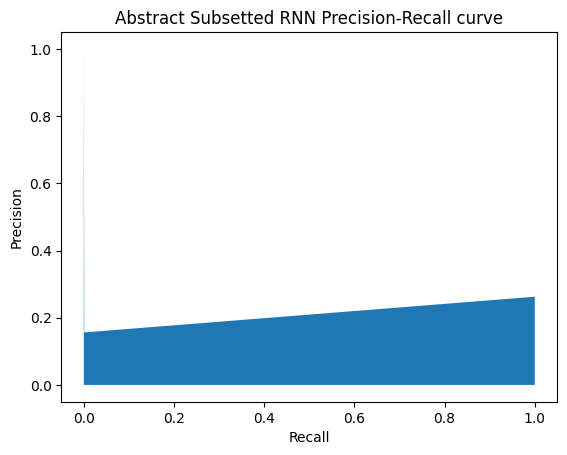

In [130]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(abs_test_subset,abs_predict_subset)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Abstract Subsetted RNN Precision-Recall curve")

RNN ABSTRACT FULL

Next we do the RNN for the full abstract dataset

In [131]:
N_EPOCHS = 10  # Number of training epochs.

best_valid_loss = float('inf')  # Initialize the best validation loss to infinity.

# Loop over the number of epochs.
for epoch in range(N_EPOCHS):

    start_time = time.time()  # Record the start time of the epoch.

    # Perform a training step for the current epoch.
    # 'train_loss' is the average loss over the training data for this epoch.
    # 'train_acc' is the average accuracy over the training data for this epoch.
    train_loss, train_acc = train(model, rnn_abs_train_loader, optimizer, criterion)

    end_time = time.time()  # Record the end time of the epoch.

    # Calculate the time taken for the epoch in minutes and seconds.
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print the results for the current epoch.
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 44s
	Train Loss: 0.585 | Train Acc: 72.95%
Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.97%
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.98%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.98%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.98%
Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.99%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.98%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.98%
Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.99%
Epoch: 10 | Epoch Time: 0m 44s
	Train Loss: 0.583 | Train Acc: 72.99%


Then we evaluate the result of the RNN on the full abstract dataset

In [132]:
abs_predict = []  # Initialize an empty list to store the model's binary predictions for the entire test set.
abs_test = []     # Initialize an empty list to store the true labels for the entire test set.

model.eval()  # Set the model to evaluation mode.

# Disable gradient calculations to save memory and computational power during inference.
with torch.no_grad():
    # Iterate over the test dataset in batches using the data loader.
    for labels, texts in rnn_abs_test_loader:
        texts = texts.to(device)  # Move the input data (texts) to the specified device (either GPU or CPU).
        labels = labels.to(device)  # Move the labels (targets) to the same device as the inputs.

        # Use the model to make predictions on the input texts.
        predictions = model(texts).squeeze(1)

        # Convert the probabilities to binary predictions (0 or 1) by rounding them.
        rounded_preds = torch.round(torch.sigmoid(predictions))

        # Convert the predictions to a list and extend the abs_predict list with these values.
        abs_predict += rounded_preds.tolist()

        # Convert the true labels to a list and extend the abs_test list with these values.
        abs_test += labels.tolist()


We then evaluate the result with weighted evaluation

In [133]:
#Convert the dataframe to array
abs_predict = np.asarray(abs_predict)
abs_test = np.asarray(abs_test)
#Printing the confusion matrix
print(confusion_matrix(abs_test,abs_predict))
#Calculating the recall
rnn_abs_recall=recall_score(abs_test,abs_predict,average='weighted')
#Calculating the precision score
rnn_abs_precision=precision_score(abs_test,abs_predict,average='weighted')
#Calculating the F1
rnn_abs_f1score=f1_score(abs_test,abs_predict,average='weighted')
#Calculating the accuracy
rnn_abs_accuracy=accuracy_score(abs_test,abs_predict)
#Calculating the matthews correlation coefficient
rnn_abs_matthews = matthews_corrcoef(abs_test,abs_predict)
#Printing the result
print('Accuracy: '+ str(rnn_abs_accuracy))
print('Macro Precision: '+ str(rnn_abs_precision))
print('Macro Recall: '+ str(rnn_abs_recall))
print('Macro F1 score:'+ str(rnn_abs_f1score))
print('MCC:'+ str(rnn_abs_matthews))

[[14065     3]
 [ 5006     0]]
Accuracy: 0.7373912131697599
Macro Precision: 0.5439473329595816
Macro Recall: 0.7373912131697599
Macro F1 score:0.6260671466774606
MCC:-0.007481749048852223


Next we do the binary evaluation

In [134]:
#Convert the dataframe to array to evaluate by binary metric
abs_predict = np.asarray(abs_predict)
abs_test = np.asarray(abs_test)
#Printing the confusion matrix
print(confusion_matrix(abs_test,abs_predict))
#Calculating the recall
rnn_abs_recall_b=recall_score(abs_test,abs_predict,average='binary')
#Calculating the precision score
rnn_abs_precision_b=precision_score(abs_test,abs_predict,average='binary')
#Calculating the F1
rnn_abs_f1score_b=f1_score(abs_test,abs_predict,average='binary')
#Calculating the accuracy
rnn_abs_accuracy_b=accuracy_score(abs_test,abs_predict)
#Calculating the matthews correlation coefficient
rnn_abs_matthews = matthews_corrcoef(abs_test,abs_predict)
#Printing the result
print('Accuracy: '+ str(rnn_abs_accuracy_b))
print('Macro Precision: '+ str(rnn_abs_precision_b))
print('Macro Recall: '+ str(rnn_abs_recall_b))
print('Macro F1 score:'+ str(rnn_abs_f1score_b))
print('MCC:'+ str(rnn_abs_matthews))

[[14065     3]
 [ 5006     0]]
Accuracy: 0.7373912131697599
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 score:0.0
MCC:-0.007481749048852223


Next we plot the precision recall curve for all the abstract dataset



Text(0.5, 1.0, 'All Abstract Dataset RNN Precision-Recall curve')

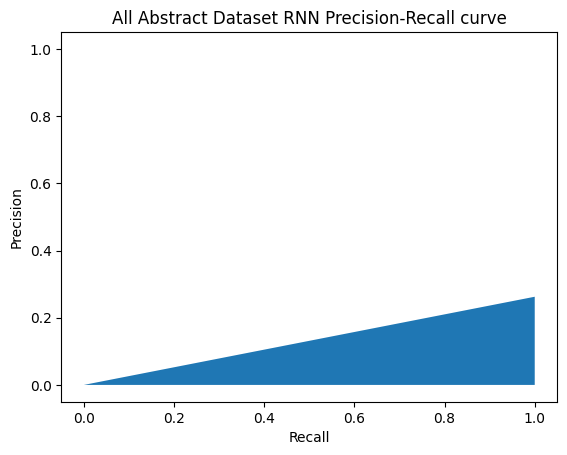

In [135]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(abs_test,abs_predict)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("All Abstract Dataset RNN Precision-Recall curve")

We then make a dictionary holding both evaluation value for weighted and binary to plot it later

In [136]:
# Create a dictionary to hold the subsetted and full abstract evaluation
rnn_abs_data_w = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'RNN_AbsFull_W': [rnn_abs_accuracy, rnn_abs_precision, rnn_abs_recall, rnn_abs_f1score],
    'RNN_AbsSubset_W': [rnn_abs_accuracy_subset, rnn_abs_precision_subset, rnn_abs_recall_subset, rnn_abs_f1score_subset]
}

# Create a pandas DataFrame from the dictionary
rnn_abs_df_w = pd.DataFrame(rnn_abs_data_w)

# Display the dictionary for the evaluation of the model
print('Weighted Evaluation for Abstract with RNN')
print(rnn_abs_df_w)

Weighted Evaluation for Abstract with RNN
      Metric  RNN_AbsFull_W  RNN_AbsSubset_W
0   Accuracy       0.737391         0.736395
1  Precision       0.543947         0.584854
2     Recall       0.737391         0.736395
3   F1-score       0.626067         0.626067


In [137]:
# Create a dictionary to hold the subsetted and full abstract evaluation
rnn_abs_data_b = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'RNN_AbsFull_B': [rnn_abs_accuracy_b, rnn_abs_precision_b, rnn_abs_recall_b, rnn_abs_f1score_b],
    'RNN_AbsSubset_B': [rnn_abs_accuracy_subset_b, rnn_abs_precision_subset_b, rnn_abs_recall_subset_b, rnn_abs_f1score_subset_b]
}

# Create a pandas DataFrame from the dictionary
rnn_abs_df_b = pd.DataFrame(rnn_abs_data_b)

# Display the dictionary for the evaluation of the model
print('Binary Evaluation for Abstract with RNN')
print(rnn_abs_df_b)

Binary Evaluation for Abstract with RNN
      Metric  RNN_AbsFull_B  RNN_AbsSubset_B
0   Accuracy       0.737391         0.736395
1  Precision       0.000000         0.156250
2     Recall       0.000000         0.000999
3   F1-score       0.000000         0.001985


RNN TITLE SUBSET

Next we'll use the RNN for the subsetted title. First we need to build the vocabulary again from the title dataset

In [138]:
# Select the 'ComputationalLinguistics' and 'title' columns from the df_train DataFrame
# and assign them to the variable rnn_vocab
rnn_vocab_title = df_train[['ComputationalLinguistics', 'title']]

# Convert the selected columns to a list of lists (where each inner list contains the values from both columns for a single row)
rnn_vocab_title = rnn_vocab_title.values.tolist()

In [139]:
# Build vocabulary
vocab_title = build_vocab_from_iterator(yield_tokens(rnn_vocab_title), specials=["<unk>"])
vocab_title.set_default_index(vocab_title["<unk>"])

# Data processing
def text_pipeline(x):
    return vocab_title(tokenizer(x))

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=vocab_title["<unk>"])

In [140]:
# Print the first 10 words in the vocabulary
print("Vocabulary Sample:", list(vocab_title.get_itos())[:10])

# Extract unique labels from the training data
unique_labels = set(label for label, _ in rnn_vocab_title)
print("Unique Labels:", unique_labels)

vocab_title_size = len(list(vocab_title.get_itos()))
print(f"Unique tokens in TEXT vocabulary: {vocab_title_size}")
print(f"Unique tokens in LABEL vocabulary: {len(unique_labels)}")

Vocabulary Sample: ['<unk>', 'for', 'and', 'of', 'a', 'with', 'in', 'learning', 'the', 'on']
Unique Labels: {0, 1}
Unique tokens in TEXT vocabulary: 78549
Unique tokens in LABEL vocabulary: 2


In [141]:
#Setting up the dimension for the input
INPUT_DIM = vocab_title_size
#Setting up the dimension for the embedding
EMBEDDING_DIM = 100
#Defining how many hidden layer
HIDDEN_DIM = 256
#Define how many output
OUTPUT_DIM = 1

#Putting it all together
model_title = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

We next define the train and evaluate for title so that it doesn't conflict with the abstract

In [142]:
def train_t(model, dataloader, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for labels, texts in dataloader:
        texts = texts.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels.float())

        acc = binary_accuracy(predictions, labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Now after building the title vocabulary we'll run the RNN on the subsetted title dataset

In [143]:
N_EPOCHS = 10  # Number of training epochs.

best_valid_loss = float('inf')  # Initialize the best validation loss to infinity.

# Loop over the number of epochs.
for epoch in range(N_EPOCHS):

    start_time = time.time()  # Record the start time of the epoch.

    # Perform a training step for the current epoch.
    # 'train_loss' is the average loss over the training data for this epoch.
    # 'train_acc' is the average accuracy over the training data for this epoch.
    train_loss, train_acc = train_t(model, rnn_title_train_loader_subset, optimizer, criterion)

    end_time = time.time()  # Record the end time of the epoch.

    # Calculate the time taken for the epoch in minutes and seconds.
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print the results for the current epoch.
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 73.34%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.582 | Train Acc: 73.63%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 73.05%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.584 | Train Acc: 73.34%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 73.34%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.578 | Train Acc: 73.93%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.583 | Train Acc: 73.34%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 72.75%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.584 | Train Acc: 73.05%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 72.75%


Now we'll evaluate the model of the subsetted title dataset

In [144]:
title_predict_subset = []  # Initialize an empty list to store the model's binary predictions for the title data in the test set.
title_test_subset = []     # Initialize an empty list to store the true labels for the title data in the test set.

model_title.eval()  # Set the model to evaluation mode

# Disable gradient calculation
with torch.no_grad():
    # Loop through the test data in batches using the rnn_title_test_loader.
    for labels, texts in rnn_title_test_loader:
        texts = texts.to(device)  # Move the input data (texts) to the specified device (CPU or GPU).
        labels = labels.to(device)  # Move the labels (targets) to the same device as the inputs.

        # Generate predictions using the model.
        predictions = model(texts).squeeze(1)

        # Apply a sigmoid function to convert the logits to probabilities and round them to get binary predictions (0 or 1).
        rounded_preds = torch.round(torch.sigmoid(predictions))

        # Convert the binary predictions to a list and extend the title_predict_subset list with these values.
        title_predict_subset += rounded_preds.tolist()

        # Convert the true labels to a list and extend the title_test_subset list with these values.
        title_test_subset += labels.tolist()


Evaluate with weighted metric

In [145]:
#Converting the dataset into array to do weighted evaluation
title_predict_subset = np.asarray(title_predict_subset)
title_test_subset = np.asarray(title_test_subset)
#Printing the confusion matrix
print(confusion_matrix(title_test_subset,abs_predict_subset))
#Calculating the recall
rnn_title_recall_subset=recall_score(title_test_subset,title_predict_subset,average='weighted')
#Calculating the precision score
rnn_title_precision_subset=precision_score(title_test_subset,title_predict_subset,average='weighted')
#Calculating the F1
rnn_title_f1score_subset=f1_score(title_test_subset,title_predict_subset,average='weighted')
#Calculating the accuracy
rnn_title_accuracy_subset=accuracy_score(title_test_subset,title_predict_subset)
#Calculating the matthews correlation coefficient
rnn_title_matthews_subset = matthews_corrcoef(title_test_subset,title_predict_subset)
#Printing the result
print('Accuracy: '+ str(rnn_title_accuracy_subset))
print('Macro Precision: '+ str(rnn_title_precision_subset))
print('Macro Recall: '+ str(rnn_title_recall_subset))
print('Macro F1 score:'+ str(rnn_title_f1score_subset))
print('MCC:'+ str(rnn_title_matthews_subset))

[[14041    27]
 [ 5001     5]]
Accuracy: 0.7373387857816923
Macro Precision: 0.5439371808273125
Macro Recall: 0.7373387857816923
Macro F1 score:0.6260415256428782
MCC:-0.008639406164072676


Evaluate with binary metric

In [146]:
#Converting the dataset into array to do binary evaluation
title_predict_subset = np.asarray(title_predict_subset)
title_test_subset = np.asarray(title_test_subset)
#Printing the confusion matrix
print(confusion_matrix(title_test_subset,abs_predict_subset))
#Calculating the recall
rnn_title_recall_subset_b=recall_score(title_test_subset,title_predict_subset,average='binary')
#Calculating the precision score
rnn_title_precision_subset_b=precision_score(title_test_subset,title_predict_subset,average='binary')
#Calculating the F1
rnn_title_f1score_subset_b=f1_score(title_test_subset,title_predict_subset,average='binary')
#Calculating the accuracy
rnn_title_accuracy_subset_b=accuracy_score(title_test_subset,title_predict_subset)
#Calculating the matthews correlation coefficient
rnn_title_matthews_subset = matthews_corrcoef(title_test_subset,title_predict_subset)
#Printing the result
print('Accuracy: '+ str(rnn_title_accuracy_subset_b))
print('Macro Precision: '+ str(rnn_title_precision_subset_b))
print('Macro Recall: '+ str(rnn_title_recall_subset_b))
print('Macro F1 score:'+ str(rnn_title_f1score_subset_b))
print('MCC:'+ str(rnn_title_matthews_subset))

[[14041    27]
 [ 5001     5]]
Accuracy: 0.7373387857816923
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 score:0.0
MCC:-0.008639406164072676


Make the precision recall curve for subsetted dataset

Text(0.5, 1.0, 'Subsetted Title Dataset RNN Precision-Recall curve')

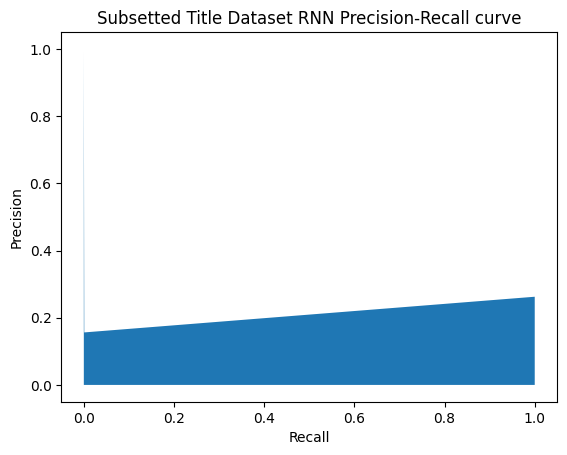

In [147]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(title_test_subset,abs_predict_subset)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Subsetted Title Dataset RNN Precision-Recall curve")

RNN TITLE FULL

Since we already build the vocabulary we just need to run the RNN on the full title dataset

In [148]:
def train_t2(model, dataloader, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for labels, texts in dataloader:
        texts = texts.to(device)  # Ensure texts are on the same device as the model
        labels = labels.to(device) # Ensure labels are on the same device as the model
        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels.float())

        acc = binary_accuracy(predictions, labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [149]:
N_EPOCHS = 10  # Number of training epochs.

best_valid_loss = float('inf')  # Initialize the best validation loss to infinity.

# Loop over the number of epochs.
for epoch in range(N_EPOCHS):

    start_time = time.time()  # Record the start time of the epoch.

    # Perform a training step for the current epoch.
    # 'train_loss' is the average loss over the training data for this epoch.
    # 'train_acc' is the average accuracy over the training data for this epoch.
    train_loss, train_acc = train_t2(model_title, rnn_title_train_loader, optimizer, criterion)

    end_time = time.time()  # Record the end time of the epoch.

    # Calculate the time taken for the epoch in minutes and seconds.
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print the results for the current epoch.
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.85%
Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.87%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.87%
Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.88%
Epoch: 05 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.90%
Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.88%
Epoch: 07 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.82%
Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.85%
Epoch: 09 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.90%
Epoch: 10 | Epoch Time: 0m 42s
	Train Loss: 0.720 | Train Acc: 28.89%


We then use the model to predict the dataset to evaluate it

In [150]:
title_predict = []  # Initialize an empty list to store the model's binary predictions for the title data in the test set.
title_test = []     # Initialize an empty list to store the true labels for the title data in the test set.

model_title.eval()  # Set the model to evaluation mode. This ensures consistent behavior during inference by disabling layers like dropout.

# Disable gradient calculation to save memory and computational resources during inference.
with torch.no_grad():
    # Loop through the test data in batches using the rnn_title_test_loader.
    for labels, texts in rnn_title_test_loader:
        texts = texts.to(device)  # Move the input data (texts) to the specified device (CPU or GPU).
        labels = labels.to(device)  # Move the labels (targets) to the same device as the inputs.

        # Generate predictions using the model. The model output is raw logits.
        predictions = model(texts).squeeze(1)

        # Apply a sigmoid function to convert the logits to probabilities and round them to get binary predictions (0 or 1).
        rounded_preds = torch.round(torch.sigmoid(predictions))

        # Convert the binary predictions to a list and extend the title_predict list with these values.
        title_predict += rounded_preds.tolist()

        # Convert the true labels to a list and extend the title_test list with these values.
        title_test += labels.tolist()

Evaluate it with weighted method

In [151]:
#Convert the dataframe into array
title_predict = np.asarray(title_predict)
title_test = np.asarray(title_test)
#Printing the confusion matrix
print(confusion_matrix(title_test,title_predict))
#Calculating the recall
rnn_title_recall=recall_score(title_test,title_predict,average='weighted')
#Calculating the precision score
rnn_title_precision=precision_score(title_test,title_predict,average='weighted')
#Calculating the F1
rnn_title_f1score=f1_score(title_test,title_predict,average='weighted')
#Calculating the accuracy
rnn_title_accuracy=accuracy_score(title_test,title_predict)
#Calculating the matthews correlation coefficient
rnn_title_matthews = matthews_corrcoef(title_test,title_predict)
#Printing the result
print('Accuracy: '+ str(rnn_title_accuracy))
print('Macro Precision: '+ str(rnn_title_precision))
print('Macro Recall: '+ str(rnn_title_recall))
print('Macro F1 score:'+ str(rnn_title_f1score))
print('MCC:'+ str(rnn_title_matthews))

[[14064     4]
 [ 5006     0]]
Accuracy: 0.7373387857816923
Macro Precision: 0.5439371808273125
Macro Recall: 0.7373387857816923
Macro F1 score:0.6260415256428782
MCC:-0.008639406164072676


Evaluate it with binary method

In [152]:
#Convert the dataframe into array to do the binary evaluation
title_predict = np.asarray(title_predict)
title_test = np.asarray(title_test)
#Printing the confusion matrix
print(confusion_matrix(title_test,title_predict))
#Calculating the recall
rnn_title_recall_b=recall_score(title_test,title_predict,average='binary')
#Calculating the precision score
rnn_title_precision_b=precision_score(title_test,title_predict,average='binary')
#Calculating the F1
rnn_title_f1score_b=f1_score(title_test,title_predict,average='binary')
#Calculating the accuracy
rnn_title_accuracy_b=accuracy_score(title_test,title_predict)
#Calculating the matthews correlation coefficient
rnn_title_matthews = matthews_corrcoef(title_test,title_predict)
#Printing the result
print('Accuracy: '+ str(rnn_title_accuracy_b))
print('Macro Precision: '+ str(rnn_title_precision_b))
print('Macro Recall: '+ str(rnn_title_recall_b))
print('Macro F1 score:'+ str(rnn_title_f1score_b))
print('MCC:'+ str(rnn_title_matthews))

[[14064     4]
 [ 5006     0]]
Accuracy: 0.7373387857816923
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 score:0.0
MCC:-0.008639406164072676


Make the precision recall curve for all title dataset

Text(0.5, 1.0, 'All Title Dataset RNN Precision-Recall curve')

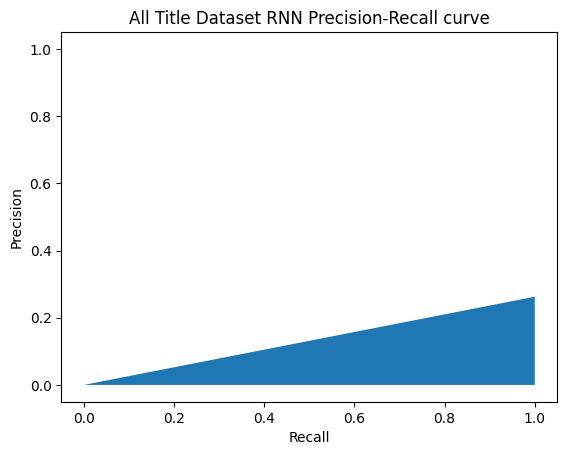

In [153]:
#Using precision recall curve to make the necessary variable to make the curve
precision, recall, thresholds = precision_recall_curve(title_test,title_predict)
#Using fill to plot the curve
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("All Title Dataset RNN Precision-Recall curve")

Making a dictionary to hold both the weighted and binary evaluation to be made into graph later

In [154]:
# Create a dictionary to hold the evaluation metric for the RNN title full weighted evaluation
rnn_title_data_w = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'RNNTitleFull_w': [rnn_title_accuracy, rnn_title_precision, rnn_title_recall, rnn_title_f1score],
    'RNNTitleSubset_w': [rnn_title_accuracy_subset, rnn_title_precision_subset, rnn_title_recall_subset, rnn_title_f1score_subset]
}

# Create a dataframe to hold the evaluation data
rnn_title_df_w = pd.DataFrame(rnn_title_data_w)

# Display the evaluation for all title and subsetted title evaluation metric
print('RNN Title Weighted Evaluation')
print(rnn_title_df_w)

RNN Title Weighted Evaluation
      Metric  RNNTitleFull_w  RNNTitleSubset_w
0   Accuracy        0.737339          0.737339
1  Precision        0.543937          0.543937
2     Recall        0.737339          0.737339
3   F1-score        0.626042          0.626042


In [155]:
# Create a dictionary to hold the evaluation metric for the RNN title full binary evaluation
rnn_title_data_b = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'RNNTitleFull_b': [rnn_title_accuracy_b, rnn_title_precision_b, rnn_title_recall_b, rnn_title_f1score_b],
    'RNNTitleSubset_b': [rnn_title_accuracy_subset_b, rnn_title_precision_subset_b, rnn_title_recall_subset_b, rnn_title_f1score_subset_b]
}

# Create a dataframe to hold the evaluation data
rnn_title_df_b = pd.DataFrame(rnn_title_data_b)

# Display the evaluation for all title and subsetted title evaluation metric
print('RNN Title Binary Evaluation')
print(rnn_title_df_b)

RNN Title Binary Evaluation
      Metric  RNNTitleFull_b  RNNTitleSubset_b
0   Accuracy        0.737339          0.737339
1  Precision        0.000000          0.000000
2     Recall        0.000000          0.000000
3   F1-score        0.000000          0.000000


Combining all the evaluation of abstract and title both binary and weighted so we can make a barchart for it

In [156]:
#Combine the evaluation metric for title and abstract
merge_df_w = abs_df_w.merge(rnn_abs_df_w, on='Metric').merge(title_df, on='Metric').merge(rnn_title_df_w, on='Metric')

#Show the dataframe
print('Evaluation metric using Weighted')
merge_df_w

Evaluation metric using Weighted


,Metric,AbsFull_W,AbsSubset_W,RNN_AbsFull_W,RNN_AbsSubset_W,TitleFull_B,TitleSubset_B,RNNTitleFull_w,RNNTitleSubset_w
0,Accuracy,0.979186,0.941910,0.737391,0.736395,0.602286,0.629496,0.737339,0.737339
1,Precision,0.979137,0.942005,0.543947,0.584854,0.607932,0.608506,0.543937,0.543937
2,Recall,0.979186,0.941910,0.737391,0.736395,0.602286,0.629496,0.737339,0.737339
3,F1-score,0.979153,0.940624,0.626067,0.626067,0.605042,0.618042,0.626042,0.626042


Plotting the dodged barchart to show the comparison of abstract and title evaluation grouping it by either weighted or binary evaluation

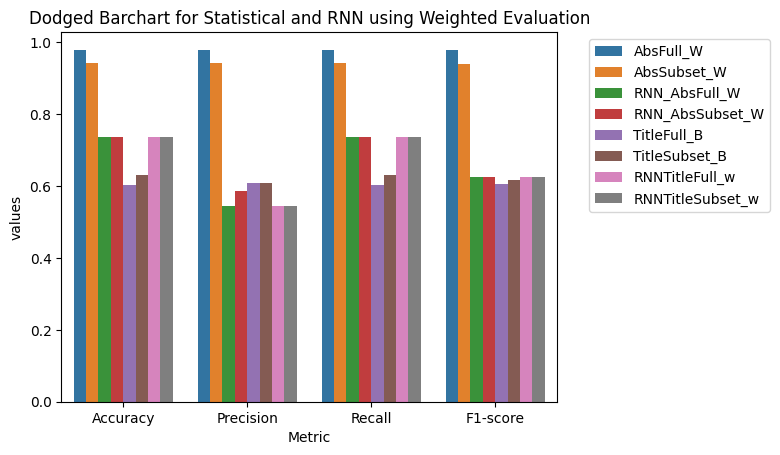

In [157]:
#Melting the dataset to be used for plotting the data
merge_melt_w = merge_df_w.melt(id_vars='Metric', var_name='variable', value_name='values')
#Calling the barplot and use the melted dataframe for the metrics
sns.barplot(x='Metric',y='values',hue='variable',data=merge_melt_w)
#Adjust the legend position so that it is outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
#Set the title of the plot
plt.title("Dodged Barchart for Statistical and RNN using Weighted Evaluation")
#Display the plot
plt.show()

In [158]:
#Combine the evaluation metric for title and abstract
merge_df_b = abs_df_b.merge(rnn_abs_df_b,  on='Metric').merge(title_df_b, on='Metric').merge(rnn_title_df_b, on='Metric')

#Show the dataframe
print('Evaluation metric using Binary')
merge_df_b

Evaluation metric using Binary


,Metric,AbsFull_B,AbsSubset_B,RNN_AbsFull_B,RNN_AbsSubset_B,TitleFull_B,TitleSubset_B,RNNTitleFull_b,RNNTitleSubset_b
0,Accuracy,0.979186,0.941910,0.737391,0.736395,0.602286,0.629496,0.737339,0.737339
1,Precision,0.964898,0.944166,0.000000,0.156250,0.253346,0.253174,0.000000,0.000000
2,Recall,0.955453,0.827607,0.000000,0.000999,0.264682,0.211147,0.000000,0.000000
3,F1-score,0.960153,0.882052,0.000000,0.001985,0.258890,0.230258,0.000000,0.000000


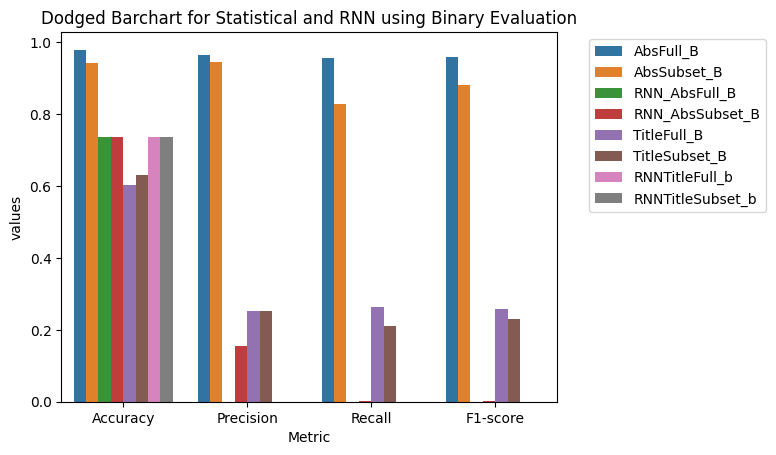

In [159]:
#Melting the dataset to be used for plotting the data
merge_melt_b = merge_df_b.melt(id_vars='Metric', var_name='variable', value_name='values')
#Calling the barplot and use the melted dataframe for the metrics
sns.barplot(x='Metric',y='values',hue='variable',data=merge_melt_b)
#Adjust the legend position so that it is outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
#Set the title of the plot
plt.title("Dodged Barchart for Statistical and RNN using Binary Evaluation")
#Display the plot
plt.show()

## **PART 2 TOPIC MODELLING**

For the next question we need to do topic modelling on the dataset. We need to do it on 1,000 and 20,000 subsetted data. For this one we'll use the abstract portion of the dataset only

In [160]:
#Changing the dataset into a list form then subsetting 1000 data from it
docs = list(svm_abs_a1)
docs = docs[:1000]
raw_docs = docs.copy()

Next we need to prepare the tokenizer

In [161]:
#Preparing the tokenizer

# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

We import the nltk to download the wordnet

In [162]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We make the code to lemmatize the documents

In [163]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

Making the copy of the docs later to be used for topic modelling by increasing the K

In [164]:
#Making the copy of the docs to be used later
docs_copy = docs.copy()

Making bigrams to be added to the docs by importing from gensim models

In [165]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

Preparing the dictionary

In [166]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

Preparing the corpus

In [167]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

Training the LDA model by setting the parameter then saving it

In [168]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

#Running the model
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)
#Saving the output file
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

Saving model in model10.gensim



Now we code the top topics so we can show the top keywords of each topics

In [169]:
top_topics = model.top_topics(corpus) #, num_words=20)
model.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.4026.


Installing the pyLDAvis to make the intertopic distance map to show the topics and show the keywords related to the topics

In [170]:
!pip install pyLDAvis
import pyLDAvis.gensim

#Plotting the intertopic distance map
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
#Showing the intertopic distance map
pyLDAvis.display(lda_display)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.2 MB/s eta 0:00:00


Next we'll build a function to get the document topics so that we're able to see what the keywords are and what are the top documents that contribute to that keyword

In [171]:
def get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs):
   # Init output
    document_topics_df = pd.DataFrame()
    data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    document_topics_df = pd.DataFrame(data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    document_topics_df['Original_Text'] = pd.Series(texts)

    return document_topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next we make a function to find the top k most representative documents for each topic

In [173]:
#This function finds the top k documents for each topic based on the percentage contribution of that topic.
def find_top_k_doc(doc_topic_df=doc_topic_df, k=3):
  # Initialize an empty DataFrame to store the sorted and filtered documents for each topic
  doc_topics_sorted_df = pd.DataFrame()
  # Group the input DataFrame by the 'Dominant_Topic' column
  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')
  # Iterate over each group (i.e., each topic)
  for i, grp in doc_topic_df_grpd:
      # Sort the documents in the current group by 'Perc_Contribution' in descending order and select the top k
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df,
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)],
                                              axis=0)
  # Reset the index of the final DataFrame and drop the old index
  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  # Rename the columns of the final DataFrame for clarity
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
#We save the topic to a variable then show it
top_k_df1 = find_top_k_doc()
top_k_df1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9968,"detection, video, feature, fine, grained, mult...",To make the best use of the underlying minut...
1,0,0.9967,"detection, video, feature, fine, grained, mult...",Video Moment Retrieval (VMR) aims at retriev...
2,0,0.9960,"detection, video, feature, fine, grained, mult...",Current multimodal models leveraging contras...
3,1,0.9972,"3d, object, image, can, real, human, data, be,...","Despite much progress, achieving real-time h..."
4,1,0.9967,"3d, object, image, can, real, human, data, be,...",The advent of deep learning has led to signi...
5,1,0.9962,"3d, object, image, can, real, human, data, be,...",Artistic style transfer is the problem of sy...
6,2,0.9962,"language, translation, text, word, system, sou...",While Neural Machine Translation (NMT) repre...
7,2,0.9961,"language, translation, text, word, system, sou...",The paper describes our participation in the...
8,2,0.9960,"language, translation, text, word, system, sou...",With little to no parallel data available fo...
9,3,0.9968,"classification, learning, data, can, research,...",A significant part of the largest Knowledge ...


Next we'll repeat the topic modelling but this time we increase the number of topics to 30

In [176]:
#Model the LDA with only unigrams, the hyperparameter is the same as the previous one
NUM_TOPICS2 = 30

#Run the model with the updated number of topics to 30
model2 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS2,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)
#Save the model
outputfile = f'model{NUM_TOPICS2}.gensim'
print("Saving model in " + outputfile)
print("")
model2.save(outputfile)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model30.gensim



Now we code the top topics so we can show the top keywords of each topics

In [177]:
top_topics2 = model2.top_topics(corpus) #, num_words=20)
model2.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence2 = sum([t[1] for t in top_topics2]) / NUM_TOPICS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we plot the intertopic distance map for the second model

In [178]:
#Showing the intertopic distance map for the second model
lda_display2 = pyLDAvis.gensim.prepare(model2, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We make the same get documents topic for the 2nd topic modelling but edit it a bit for the 2nd model

In [179]:
def get_document_topics2(ldamodel=model2, corpus=corpus, texts=raw_docs):
   # Init output
    document_topics_df = pd.DataFrame()
    data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    document_topics_df = pd.DataFrame(data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    document_topics_df['Original_Text'] = pd.Series(texts)

    return document_topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
doc_topic_df2 = get_document_topics2(ldamodel=model2, corpus=corpus, texts=raw_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Again, make the find top k function but catered for the 2nd model

In [181]:
def find_top_k_doc2(doc_topic_df=doc_topic_df2, k=3):
  # Initialize an empty DataFrame to store the sorted and filtered documents for each topic
  doc_topics_sorted_df = pd.DataFrame()
  # Group the input DataFrame by the 'Dominant_Topic' column
  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')
  # Iterate over each group (i.e., each topic)
  for i, grp in doc_topic_df_grpd:
      # Sort the documents in the current group by 'Perc_Contribution' in descending order and select the top k
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df,
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)],
                                              axis=0)
  # Reset the index of the final DataFrame and drop the old index
  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  # Rename the columns of the final DataFrame for clarity
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Showing the keywords and the document contributing the most to that keywords and topic

In [182]:
#Saving the top k then showing it
top_k_df2 = find_top_k_doc2()
top_k_df2.head(30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9899,"video, frame, temporal, problem, level, framew...",Inverse problems defined naturally on the sp...
1,0,0.8481,"video, frame, temporal, problem, level, framew...",Video grounding aims to locate the timestamp...
2,0,0.8476,"video, frame, temporal, problem, level, framew...",Adversarial perturbations are noise-like pat...
3,1,0.9955,"3d, shape, object, reconstruction, can, be, im...","Despite much progress, achieving real-time h..."
4,1,0.9919,"3d, shape, object, reconstruction, can, be, im...",A radar system emits probing signals and rec...
5,1,0.9912,"3d, shape, object, reconstruction, can, be, im...",Digitisation of natural history collections ...
6,2,0.9930,"attention, transformer, context, decoder, end,...",The rapid spread of information over social ...
7,2,0.9915,"attention, transformer, context, decoder, end,...","We present HyperSeg, a hyperdimensional comp..."
8,2,0.9437,"attention, transformer, context, decoder, end,...",Vision Transformer (ViT) attains state-of-th...
9,3,0.9951,"task, text, such, network, be, or, can, also, ...",Multi-Task Learning (MTL) aims to learn mult...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next we'll do the topic modelling for 20,000 subsetted abstract data. Then we'll repeat the same process but also increasing the topic number to 30

In [183]:
#Saving the 20,000 subsetted abstract documents
docs_abs = list(svm_abs_a1)
docs_abs = docs_abs[:20000]
#Making a copy for the raw docs
raw_docs = docs_abs.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Preparing the tokenizer for the 20,000 abstract documents

In [184]:
#Preparing the tokenizer

# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs_abs)):
    docs_abs[idx] = docs_abs[idx].lower()  # Convert to lowercase.
    docs_abs[idx] = tokenizer.tokenize(docs_abs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs_abs = [[token for token in doc if not token.isnumeric()] for doc in docs_abs]

# Remove words that are only one character.
docs_abs = [[token for token in doc if len(token) > 1] for doc in docs_abs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [185]:
docs_abs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs_abs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Adding bigrams to the docs

In [186]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram_abs = Phrases(docs_abs, min_count=20)
for idx in range(len(docs_abs)):
    for token in bigram[docs_abs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_abs[idx].append(token)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create the dictionary

In [187]:
# Create a dictionary representation of the documents.
dictionary_abs = Dictionary(docs_abs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_abs.filter_extremes(no_below=20, no_above=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create the corpus

In [188]:
corpus_abs = [dictionary_abs.doc2bow(doc) for doc in docs_abs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running the model for the 20,000 subsetted data. The hyperparameter has been set before so nothing need to be added

In [189]:
# Make a index to word dictionary.
temp = dictionary_abs[0]  # This is only to "load" the dictionary.
id2word = dictionary_abs.id2token
#Running the model
model_abs = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)
#Saving the model
outputfile_abs = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile_abs)
print("")
model_abs.save(outputfile)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model10.gensim



Coding the top topics for the 20,000 subsetted abstract

In [190]:
top_topics_abs = model_abs.top_topics(corpus_abs) #, num_words=20)
model_abs.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics_abs]) / NUM_TOPICS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plotting the intertopic distance map for the 3rd model

In [191]:
#Plotting the Intertopic Distance Map
lda_display_abs = pyLDAvis.gensim.prepare(model_abs, corpus_abs, dictionary_abs, sort_topics=False)
pyLDAvis.display(lda_display_abs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We make the same get documents topic for the 2nd topic modelling but edit it a bit for the 2nd model

In [192]:
def get_document_topics3(ldamodel=model_abs, corpus=corpus, texts=raw_docs):
   # Init output
    document_topics_df = pd.DataFrame()
    data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    document_topics_df = pd.DataFrame(data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    document_topics_df['Original_Text'] = pd.Series(texts)

    return document_topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [193]:
doc_topic_df3 = get_document_topics3(ldamodel=model_abs, corpus=corpus, texts=raw_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Code the find top k doc again but with the third modelling data

In [194]:
def find_top_k_doc3(doc_topic_df=doc_topic_df3, k=3):
  # Initialize an empty DataFrame to store the sorted and filtered documents for each topic
  doc_topics_sorted_df = pd.DataFrame()
  # Group the input DataFrame by the 'Dominant_Topic' column
  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')
  # Iterate over each group (i.e., each topic)
  for i, grp in doc_topic_df_grpd:
      # Sort the documents in the current group by 'Perc_Contribution' in descending order and select the top k
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df,
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)],
                                              axis=0)

  # Reset the index of the final DataFrame and drop the old index
  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  # Rename the columns of the final DataFrame for clarity
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Show the top k documents representing the keyword and topic

In [195]:
#Showing the top k document
top_k_df3 = find_top_k_doc3()
top_k_df3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9975,"experimented, evaluate, at, result_show, order...",Human-Object Interaction (HOI) detection is ...
1,0,0.9973,"experimented, evaluate, at, result_show, order...","In text-video retrieval, recent works have b..."
2,0,0.9973,"experimented, evaluate, at, result_show, order...",The core idea of metric-based few-shot image...
3,1,0.9970,"projected, introduced, mode, however, hybrid, ...",Existing large language models (LLMs) can on...
4,1,0.4964,"projected, introduced, mode, however, hybrid, ...","We present an accurate, fast and efficient m..."
5,1,0.4851,"projected, introduced, mode, however, hybrid, ...","Despite considerable recent progress, the cr..."
6,2,0.9977,"hence, employ, fine, however, evaluate, requir...",A large labeled dataset is a key to the succ...
7,2,0.9977,"hence, employ, fine, however, evaluate, requir...",Clustering aims to group similar objects tog...
8,2,0.9976,"hence, employ, fine, however, evaluate, requir...",Semi-supervised semantic segmentation (SSS) ...
9,3,0.9956,"valid, training, evaluate, clinical, employ, g...",A movie that is thoroughly enjoyed and recom...


Next we'll repeat the topic modelling but increasing the number of topics to 30

In [196]:
#Running the model again but with K = 30. K is already set earlier
model_abs2 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS2,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)
#Saving the output
outputfile_abs2 = f'model{NUM_TOPICS2}.gensim'
print("Saving model in " + outputfile_abs2)
print("")
model_abs2.save(outputfile)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model30.gensim



Get the top topics

In [203]:
top_topics_abs2 = model_abs2.top_topics(corpus_abs) #, num_words=20)
model_abs2.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics_abs2]) / NUM_TOPICS


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot the intertopic distance map for model 4

In [198]:
#Plot the intertopic distance map
lda_display_abs2 = pyLDAvis.gensim.prepare(model_abs2, corpus_abs, dictionary_abs, sort_topics=False)
pyLDAvis.display(lda_display_abs2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Make the function again for model 4 with the 4th modelling data

In [199]:
def get_document_topics4(ldamodel=model_abs2, corpus=corpus, texts=raw_docs):
   # Init output
    document_topics_df = pd.DataFrame()
    data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    document_topics_df = pd.DataFrame(data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    document_topics_df['Original_Text'] = pd.Series(texts)

    return document_topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [200]:
doc_topic_df4 = get_document_topics4(ldamodel=model_abs, corpus=corpus, texts=raw_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Make the find top k doc 4 again with data from model 4

In [201]:
def find_top_k_doc4(doc_topic_df=doc_topic_df4, k=3):
  # Initialize an empty DataFrame to store the sorted and filtered documents for each topic
  doc_topics_sorted_df = pd.DataFrame()
  # Group the input DataFrame by the 'Dominant_Topic' column
  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

  for i, grp in doc_topic_df_grpd:
      # Sort the documents in the current group by 'Perc_Contribution' in descending order and select the top k
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df,
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)],
                                              axis=0)

  # Reset the index of the final DataFrame and drop the old index
  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  # Rename the columns of the final DataFrame for clarity
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Show the top k document for model 4

In [202]:
#Show the top k document for model 4
top_k_df4 = find_top_k_doc4()
top_k_df4.head(30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9975,"experimented, evaluate, at, result_show, order...",Human-Object Interaction (HOI) detection is ...
1,0,0.9973,"experimented, evaluate, at, result_show, order...",The core idea of metric-based few-shot image...
2,0,0.9973,"experimented, evaluate, at, result_show, order...","In text-video retrieval, recent works have b..."
3,1,0.9970,"projected, introduced, mode, however, hybrid, ...",Existing large language models (LLMs) can on...
4,1,0.4964,"projected, introduced, mode, however, hybrid, ...","We present an accurate, fast and efficient m..."
5,1,0.4853,"projected, introduced, mode, however, hybrid, ...","Despite considerable recent progress, the cr..."
6,2,0.9977,"hence, employ, fine, however, evaluate, requir...",A large labeled dataset is a key to the succ...
7,2,0.9977,"hence, employ, fine, however, evaluate, requir...",Clustering aims to group similar objects tog...
8,2,0.9976,"hence, employ, fine, however, evaluate, requir...",Semi-supervised semantic segmentation (SSS) ...
9,3,0.9956,"valid, training, evaluate, clinical, employ, g...",A movie that is thoroughly enjoyed and recom...
